In [1]:
# All imports/seeds
import torch
from torch import nn
from model.mlp import MLP
from dataloader.utils import get_val_test_ids
from personal_utils import  (get_models_and_files, get_dataloaders_and_datasets,
                             get_embedding_files, send_through_model, send_through_patch_model,
                             send_through_decoder, generate_saliency_map, plot_saliency_map, alter_q_data, plot_reconstruction_difference)
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [2]:
from model.vq_vae import VectorQuantizedVAE
from model.vq_vae_patch_embedd import VQVAEPatch

_, _, _, train_data, val_data, test_data, train_labels, val_labels, test_labels = get_dataloaders_and_datasets()
vqvae_v1_files = dict(model='VQ-VAE-asimow-best.ckpt', mlp='my_trained_mlp.ckpt', q_emb='q_emb_v1.npy', q_ind='q_ind_v1.npy', type='VQ-VAE')
patch_vqvae_v1_files = dict(model='VQ-VAE-Patch-best-v1.ckpt', mlp='my_trained_mlp_on_patch_v1.ckpt', q_emb='patch_q_emb_v1.npy', q_ind='patch_q_ind_v1.npy', type='VQ-VAE-Patch')
patch_vqvae_v2_files = dict(model='VQ-VAE-Patch-best-v2.ckpt', mlp='my_trained_mlp_on_patch_v2.ckpt', q_emb='patch_q_emb_v2.npy', q_ind='patch_q_ind_v2.npy', type='VQ-VAE-Patch')
patch_vqvae_v4_files = dict(model='VQ-VAE-Patch-best-v4.ckpt', mlp='my_trained_mlp_on_patch_v4.ckpt', q_emb='patch_q_emb_v4.npy', q_ind='patch_q_ind_v4.npy', type='VQ-VAE-Patch')
patch_vqvae_v5_files = dict(model='VQ-VAE-Patch-best-v5.ckpt', mlp='my_trained_mlp_on_patch_v5.ckpt', q_emb='patch_q_emb_v5.npy', q_ind='patch_q_ind_v5.npy', type='VQ-VAE-Patch')
y_patch_vqvae_files = dict(model='Y-VQ-VAE-Patch-best.ckpt', mlp='my_trained_mlp_on_y_patch.ckpt', q_emb='y_patch_q_emb.npy', q_ind='y_patch_q_ind.npy', type='VQ-VAE-Patch')

def get_files_and_models(files: dict):
    # extract file paths from files dict
    model_path = f"./model_checkpoints/{files['type']}/{files['model']}"
    mlp_path = f"./MLPs/{files['mlp']}"
    q_emb_path = f"./created_files/{files['q_emb']}"
    q_ind_path = f"./created_files/{files['q_ind']}"

    # load model
    model_dict = torch.load(model_path, map_location=torch.device('cpu'))
    hparams = model_dict['hyper_parameters']
    if files['type']=='VQ-VAE':
        # hparams.pop('logger')
        model = VectorQuantizedVAE(**hparams)
        model.load_state_dict(model_dict['state_dict'])

    elif files['type']=='VQ-VAE-Patch':
        if 'use_improved_vq' not in hparams: hparams['use_improved_vq'] = None
        model = VQVAEPatch(**hparams)
        model.load_state_dict(model_dict['state_dict'])
    model.eval()

    # load mlp
    my_mlp = MLP(input_size=model.enc_out_len, output_size=2, in_dim=model.embedding_dim, hidden_sizes=512)
    my_mlp.load_state_dict(torch.load(mlp_path))
    my_mlp.eval()

    # extract codebook and load quantized embeddings
    if files['type']=='VQ-VAE-Patch' and hparams["use_improved_vq"]:
        codebook = torch.round(model.vector_quantization.vq.codebooks[0], decimals=3)
    else:
        codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)
    q_emb = torch.round(torch.tensor(np.load(q_emb_path), dtype=torch.float32), decimals=3)
    q_ind = np.load(q_ind_path)
    return dict(model=model, mlp=my_mlp, codebook=codebook, q_emb=q_emb, q_ind=q_ind, hparams=hparams, type=files['type'])

# get dicts for every trained model combination containing model, mlp, codebook, q_emb, q_ind, hparams, type (VQ-VAE or VQ-VAE-Patch)
vqvae_v1 = get_files_and_models(vqvae_v1_files)
patch_vqvae_v1 = get_files_and_models(patch_vqvae_v1_files)
patch_vqvae_v2 = get_files_and_models(patch_vqvae_v2_files)
patch_vqvae_v4 = get_files_and_models(patch_vqvae_v4_files)
patch_vqvae_v5 = get_files_and_models(patch_vqvae_v5_files)
y_patch_vqvae = get_files_and_models(y_patch_vqvae_files)


In [4]:
vqvae_v1["hparams"]

{'hidden_dim': 32,
 'input_dim': 2,
 'num_embeddings': 256,
 'embedding_dim': 32,
 'n_resblocks': 1,
 'learning_rate': 0.001,
 'seq_len': 200,
 'dropout_p': 0.1,
 'decoder_type': 'Conv'}

torch.Size([200, 2])
torch.Size([200, 1])


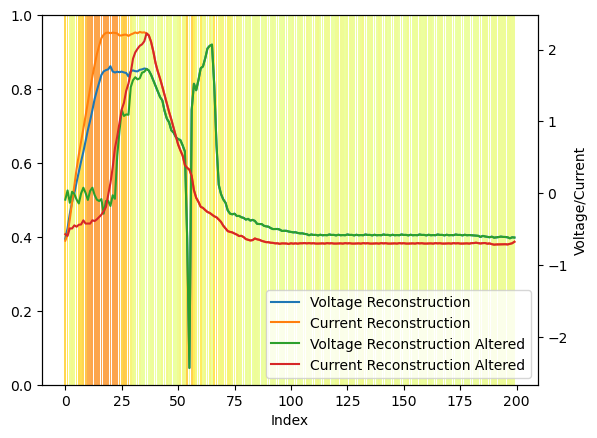

Originl Q-Embeddings Indices:  [ 47  49 207 207 207 149 251  87  88 116 151 214 214 133 133 133 133 133
 133 133 133 133 133 133 133  98]
Changed Q-Embeddings Indices:  [ 33  33  33  33 207 149 251  87  88 116 151 214 214 133 133 133 133 133
 133 133 133 133 133 133 133  98]
Total Differences:  tensor(34.2698, dtype=torch.float64)


In [17]:
def plot_reconstruction_difference_v2(reconstructed_original, reconstructed_changed, original, label, plot_original=False):
    print(original.shape)
    my_test = reconstructed_changed[:,0].clone()
    my_test = my_test.reshape(-1,1)
    my_test_2 = original[:,0].clone()
    my_test_2 = my_test_2.reshape(-1,1)
    print(my_test.shape)

    # difference = []
    difference = torch.sum(torch.abs(my_test - my_test_2), dim=1)
    difference_extreme = torch.where(difference > 0, 1.0, 0.0).clone().detach()
    colormap = plt.colormaps['Wistia']
    fig, ax = plt.subplots()
    # fig.set_size_inches(12, 7)
    ax2 = ax.twinx()
    bars = ax.bar(np.arange(len(reconstructed_original)), [1] * len(reconstructed_original), color=colormap(difference), alpha=0.7)
    # colormap = plt.colormaps['binary']
    # bars_impact = ax.bar([0,83,93,195], [1] * 4, color=colormap(np.ones(shape = (4,))), alpha=1)
    # bars_impact = ax.bar([28,60,140, 172], [1] * 4, color=colormap(np.ones(shape = (4,))), alpha=1)
    # ax.plot(difference, color='black', linewidth=2)
    ax.set_ylim(0, 1)
    # ax2.set_ylim(-5, 5)
    ax.set_xlabel('Index')
    # ax.set_ylabel('Difference')
    ax2.set_ylabel('Voltage/Current')
    ax2.plot(reconstructed_original)
    # ax.plot(reconstructed_original)

    # add legend with Voltage and Current

    ax2.plot(reconstructed_changed)
    # label fig
    ax2.legend(['Voltage Reconstruction', 'Current Reconstruction', 'Voltage Reconstruction Altered', 'Current Reconstruction Altered'], loc='lower right')

    # ax.set_title(f'Difference between Original and Changed Reconstruction for {label}')
    # if plot_original: ax2.plot(original)
    plt.show()
    return difference

def plot_reconstruction_difference_multiple_next_to_each_other(reconstructed_original, reconstructed_changed, original, label, plot_original=False, x_counter=0, value=0.0):
    difference = torch.sum(torch.abs(reconstructed_original - reconstructed_changed), dim=1)
    difference_extreme = torch.where(difference > 0, 1.0, 0.0).clone().detach()
    colormap = plt.colormaps['Wistia']
    # fig, ax = plt.subplots()
    ax[x_counter].set_xlabel('Index')
    # ax.set_ylabel('Difference')
    ax[x_counter].set_ylabel('Voltage/Current')
    ax[x_counter].plot(reconstructed_original)
    ax[x_counter].plot(reconstructed_changed)
    # label fig
    ax[x_counter].set_title(f'each 2nd embedding dimension value set to {value}')

    ax[x_counter].legend(['Voltage Reconstruction', 'Current Reconstruction', 'Voltage Reconstruction Altered', 'Current Reconstruction Altered'], loc='lower right')
    # plt.show()
    return difference

def alter_q_data_v2(model_dict, test_dpt, original_data, alter_range, alter_embedding, plot_original=False):
    q_emb = model_dict["q_emb"][test_dpt]
    q_ind = model_dict["q_ind"][test_dpt]
    model = model_dict["model"]
    model_hparams = model_dict["hparams"]
    label = model_dict["type"]

    if 'use_improved_vq' not in model_hparams: model_hparams['use_improved_vq'] = None
    if model_hparams["use_improved_vq"]:
        # codebook = torch.round(model.vector_quantization.vq.codebooks[0], decimals=3)
        codebook = model.vector_quantization.vq.codebooks[0]
    else:
        codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)
        # codebook = model.vector_quantization.embedding.weight.data

    changed_q_data = q_emb.clone().detach()
    changed_q_indices = q_ind.copy()
    # for p in range(2):
    test_embeds = [221, 85, 134, 214]
    test_embeds_2 = [47, 49, 207, 207, 207, 149, 251, 87, 88, 116]
    test_embeds_3 = [207, 207, 149, 251, 87, 88, 116, 151]
    test_embeds_4 = [49, 207, 207, 207, 149, 251, 87, 88, 116, 151]
    for j,i in enumerate(alter_range):
        # alter_embedding = test_embeds[j]
        changed_q_indices[i] = alter_embedding
        # altered_data = q_emb[i].clone()
        # valuess = [0.0, -2.1350, 2.4010]
        # altered_data[0:32:2] = valuess[1]
        # altered_data[0:32:2] = -2.1350
        # altered_data[0:32:2] = 2.4010
        # altered_data[:] = 2.4010
        # altered_data[:16] = -2.1350
        changed_q_data[i] = codebook[alter_embedding] 
        # changed_q_data[i] = altered_data
        if label=='VQ-VAE-Patch':
            changed_q_indices[i+8] = alter_embedding
            changed_q_data[i+8] = codebook[alter_embedding] 

    reconstructed_original, _= send_through_decoder(model=model, q_data=q_emb.unsqueeze(0), original_data = original_data, label=label)
    reconstructed_changed, _= send_through_decoder(model=model, q_data=changed_q_data.unsqueeze(0), original_data = original_data, label=label)
    difference = plot_reconstruction_difference_v2(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=original_data, label=label, plot_original=plot_original)

    # difference = plot_reconstruction_difference_multiple_next_to_each_other(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=original_data, label=label, plot_original=plot_original, x_counter=p, value=valuess[p])
    # partial_difference = torch.sum(torch.abs(reconstructed_original[0][5:84] - reconstructed_changed[0][117:196]), dim=1)
    # print(partial_difference)
    # count 0.000s in partial difference
    # print(len(np.where(partial_difference == 0)[0]))

    return changed_q_data, changed_q_indices, difference

test_dpt = 3
original_data =torch.tensor(train_data[test_dpt])

current_model = get_files_and_models(vqvae_v1_files)
# fig, ax = plt.subplots(1,2)
# fig.set_size_inches(14, 5)
counter = 0
# ax.plot(original_data)
# create empty tensor for summing up differencs
all_differences = torch.zeros(200)

# for i in range(0,24):
changed_q_data, changed_q_indices, difference = alter_q_data_v2(current_model, test_dpt, original_data, range(0, 4), 33)
# print("Originl Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])
# my_difference = np.where(difference > 0)[0]
# if len(my_difference) > 0:
#     print(np.where(difference > 0)[0][0], np.where(difference > 0)[0][-1])
#     print("Amount of Differences: ", len(np.where(difference > 0)[0]))
# else:
#     print("No Differences for ", i)
# all_differences += difference
# print(my_difference)
# ax.plot(all_differences, color='black', linewidth=2)
colormap = plt.colormaps['Wistia']
# print(min(all_differences), max(all_differences))

# scale data
denominator = max(all_differences) - 0
scaled_data = [(datum-min(all_differences))/denominator for datum in all_differences]

# bars = ax.bar(np.arange(len(original_data)), [1] * len(original_data), color=colormap(scaled_data), alpha=1)
# plt.show()

print("Originl Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])
print("Changed Q-Embeddings Indices: ", changed_q_indices)
print("Total Differences: ", torch.sum(difference))


### Inputwise Alteration
Changing every second value to 0.0000
- Total Differences: 98.1721
- Current: 50.2132
- Voltage: 47.9589

Changin every second value to -2.1350
- Total Differences: 298.4066
- Current: 112.5607
- Voltage: 185.8459

Changing nothing
- Total Differences: 16.8694
- Current: 10.2924
- Voltage: 6.5770

In [185]:
print(current_model["codebook"].max())
print(current_model["codebook"].min())
print(current_model["codebook"].mean())
print(current_model["q_emb"].max())
print(current_model["q_emb"].min())
# print the max value of every dimension among all q-embeddings without sorting it
# print(current_model["codebook"].max(dim=0))
# print(current_model["codebook"].min(dim=0))
# print(current_model["codebook"].mean(dim=0).float())
print(current_model["codebook"][207])
# create a tensor with 32 values of 0.0
zeros_t = torch.zeros(32)
# create a tensor with 32 values of 0.1
ones_t = torch.ones(32) * 0.1

difference =current_model["codebook"][207] - ones_t
print(difference.sum())

tensor(2.4010)
tensor(-2.1350)
tensor(0.0005)
tensor(2.4010)
tensor(-2.1350)
tensor([ 0.1480,  0.1030,  0.9970,  1.3250,  0.0600, -0.1840, -0.9430,  0.0470,
        -1.5640,  0.4410, -0.4960,  1.3880, -1.3740,  0.6360, -0.7900, -1.2760,
        -0.9160, -0.0990, -0.0160, -1.0270, -0.7280,  0.1210,  0.3570,  0.2760,
        -0.1060,  0.6460,  0.4080, -0.5850,  0.2700, -1.2600,  0.1250,  0.2990])
tensor(-6.9170)


[ 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155]
21 155
Amount of Differences:  135
Q Indices before:  [ 47  49 207 207 207 149 251  87  88 116 151 214 214 133 133 133 133 133
 133 133 133 133 133 133 133  98]
Q Indices after:  [ 47  49 207 207 207 207  53 188 149 207 207 207 124  40  95 221 119   3
 214 133 133 133 133 133 133  98]


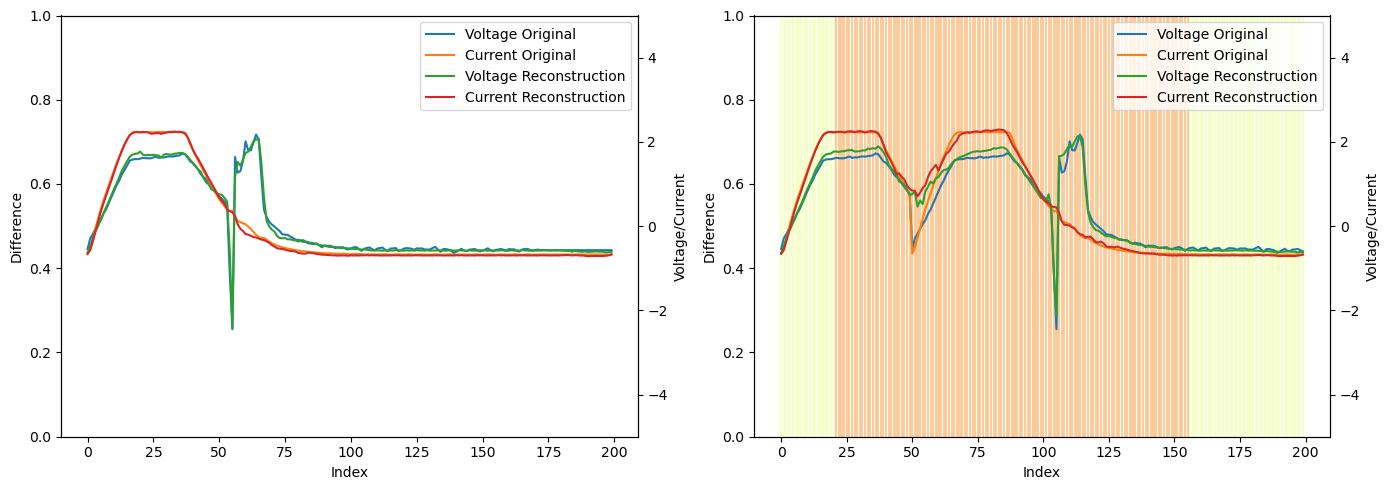

In [37]:
def plot_reconstruction_difference_v3(reconstructed_original, reconstructed_changed, original, label, plot_original=False, column_plot=0):
    difference = torch.sum(torch.abs(reconstructed_original - reconstructed_changed), dim=1)
    difference_extreme = torch.where(difference > 0, 1.0, 0.0).clone().detach()
    colormap = plt.colormaps['Wistia']
    # fig, ax = plt.subplots()
    # fig.set_size_inches(12, 7)
    ax2 = ax[column_plot].twinx()
    if plot_original: ax2.plot(original)
    if column_plot ==1:bars = ax[column_plot].bar(np.arange(len(reconstructed_original)), [1] * len(reconstructed_original), color=colormap(difference_extreme), alpha=0.4)
    # ax.plot(difference, color='black', linewidth=0.5)
    ax[column_plot].set_ylim(0, 1)
    ax2.set_ylim(-5, 5)
    ax[column_plot].set_xlabel('Index')
    ax[column_plot].set_ylabel('Difference')
    ax2.set_ylabel('Voltage/Current')
    ax2.plot(original)
    if column_plot == 0:
        ax2.plot(reconstructed_original)
    else:
        ax2.plot(reconstructed_changed)
    # label fig
    # ax.set_title(f'Difference between Original and Changed Reconstruction for {label}')
    
    # add legend to plot
    ax2.legend(['Voltage Original', 'Current Original', 'Voltage Reconstruction', 'Current Reconstruction'], loc='upper right')
    # plt.show()
    return difference

def alter_input_data(original_data, alter_slice, alter_value, model, label, plot_altered=False, write_csv=False):
    altered_input = original_data.clone()
    # altered_input[alter_slice]=torch.tensor([alter_value, alter_value])
    altered_input[50:200] = original_data[:150]
    # print(altered_input)
    if label == "VQ-VAE":
        _, _, _, q_data, q_indices, _, _ = send_through_model(model, original_data.unsqueeze(0), reconstruct=False)
        _, _, _, changed_q_data, changed_q_indices, _, _ = send_through_model(model, altered_input.unsqueeze(0), reconstruct=False)
    else:
        _, _, _, q_data, q_indices, _, _ = send_through_patch_model(model, original_data.unsqueeze(0), reconstruct=False)
        _, _, _, changed_q_data, changed_q_indices, _, _ = send_through_patch_model(model, altered_input.unsqueeze(0), reconstruct=False)

    # correcr dimensions, so that its always [enc_out_len, 1], because Residual VQ returns Indices in 3 dimensions (num_quantizers, enc_out_len, 1)

    q_indices = q_indices.reshape(-1).unsqueeze(1)
    changed_q_indices = changed_q_indices.reshape(-1).unsqueeze(1)
    changed_q_data = torch.round(changed_q_data, decimals=3)
    q_data = torch.round(q_data, decimals=3)
    reconstructed_original, _= send_through_decoder(model=model, q_data=q_data, original_data = original_data, label=label)
    reconstructed_changed, _= send_through_decoder(model=model, q_data=changed_q_data, original_data = original_data, label=label)
    original_data_list = [original_data, altered_input]
    for i in range(2):
        if  not write_csv: difference = plot_reconstruction_difference_v3(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=original_data_list[i], label=label, plot_original=plot_altered, column_plot=i)
    difference = torch.sum(torch.abs(reconstructed_original[0] - reconstructed_changed[0]), dim=1)

    difference_indices = np.where(difference > 0)[0]
    # print(difference[difference_indices])
    print(difference_indices)
    first_difference = None
    last_difference = None
    if len(difference_indices) > 0:
        print(difference_indices[0], difference_indices[-1])
        first_difference = difference_indices[0]
        last_difference = difference_indices[-1]
        print("Amount of Differences: ", len(difference_indices))
    else:
        print("No Differences for ", i)

    print("Q Indices before: ", np.array(q_indices).reshape(q_indices.shape[0],))
    print("Q Indices after: ", np.array(changed_q_indices).reshape(q_indices.shape[0],))
    similarity = np.array(q_indices==changed_q_indices).reshape(26,)
    different_indices = q_indices[~similarity].numpy().reshape(-1)
    different_changed_indices = changed_q_indices[~similarity].numpy().reshape(-1)
    # print(similarity)
    # print(np.where(similarity==False))
    # print("")
    # ergebnis_schreiben([alter_slice, original_data[alter_slice], altered_input[alter_slice], np.where(similarity==False), len(np.where(similarity==False)[0]), str(str(difference_indices[0]) + "-" + str(difference_indices[-1])), ""])
    ergebnis_schreiben([alter_slice, alter_value, np.where(similarity==False)[0], different_indices, different_changed_indices, len(np.where(similarity==False)[0]), str(str(first_difference) + "-" + str(last_difference)), len(difference_indices)])
    return changed_q_data, changed_q_indices
test_dpt = 3
original_data = torch.from_numpy(train_data[test_dpt]).float()

fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 5)


import csv
csvfile = open('result_input_altering.csv', 'w', newline='')
writer = csv.writer(csvfile)
writer.writerow(["Changed Input Range", "New Value", "Affected Embeddings", "Original Embeddings", "New Embeddings", "Amount Affected Embeddings", "Affected Reconstruction Range", "Affected Reconstruction Datapoints"])   
csvfile.close()

def ergebnis_schreiben(my_row):
    csvfile = open('result_input_altering.csv', 'a', newline='')
    writer = csv.writer(csvfile)
    writer.writerow(my_row)   
    csvfile.close()


current_model = get_files_and_models(vqvae_v1_files)
step = 100
# for i in range(100,200-step+1, step):
i_changed_q_data, i_changed_q_indices = alter_input_data(original_data=original_data, alter_slice=slice(100, 110),
                                                            alter_value=4, model=current_model["model"], label="VQ-VAE",
                                                            plot_altered=False, write_csv=False)

plt.tight_layout()
plt.show()

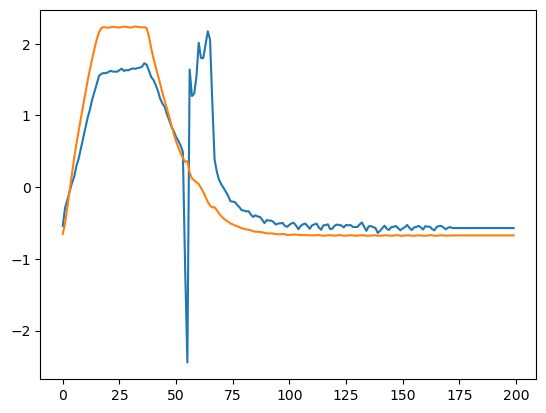

In [132]:
test_dpt = 3
original_data = torch.from_numpy(train_data[test_dpt]).float()

plt.plot(original_data)

In [174]:
# i_changed_q_data, i_changed_q_indices
q_ind = vqvae_v1["q_ind"][0]
model = vqvae_v1["model"]
codebook = vqvae_v1["codebook"]
codebook = model.vector_quantization.embedding.weight.data

print(q_ind)
print(np.array(i_changed_q_indices.reshape(q_ind.shape[0],)))
print(np.array(i_changed_q_indices.reshape(q_ind.shape[0],))[13])
print(i_changed_q_data[0][13])
print(codebook[221])
print(i_changed_q_data[0][13] == codebook[221])

new_c = torch.round(codebook[221], decimals=3)
new_i = torch.round(i_changed_q_data[0][13], decimals=3)

print(new_i == new_c)

[228 154 149 149 149 149 100 188 120 240   3 214 214 133 133 133 133 133
 133 133 133 133 133 133 133  98]
[228 154 149 149 149 149 100 188 120 240   3 214 214 221  85 134 214 133
 133 133 133 133 133 133 133  98]
221
tensor([-0.3266, -0.5731, -1.1848, -1.2992, -0.5261,  0.5971, -1.9863, -0.5365,
        -0.0816, -1.6874, -0.3961,  0.1795, -0.5651,  1.5446, -0.4117,  0.8418,
         1.2858,  1.5822,  0.1510, -1.0958,  0.3766, -0.8919,  2.1864,  1.6029,
        -0.2750,  0.7810,  0.8545,  0.5629,  0.7775,  1.1263,  0.2430, -0.3307])
tensor([-0.3266, -0.5731, -1.1848, -1.2992, -0.5261,  0.5971, -1.9863, -0.5365,
        -0.0816, -1.6874, -0.3961,  0.1795, -0.5651,  1.5446, -0.4117,  0.8418,
         1.2858,  1.5822,  0.1510, -1.0958,  0.3766, -0.8919,  2.1864,  1.6029,
        -0.2750,  0.7810,  0.8545,  0.5629,  0.7775,  1.1263,  0.2430, -0.3307])
tensor([False, False,  True,  True,  True, False, False, False, False,  True,
        False, False,  True,  True, False, False,  True,  True

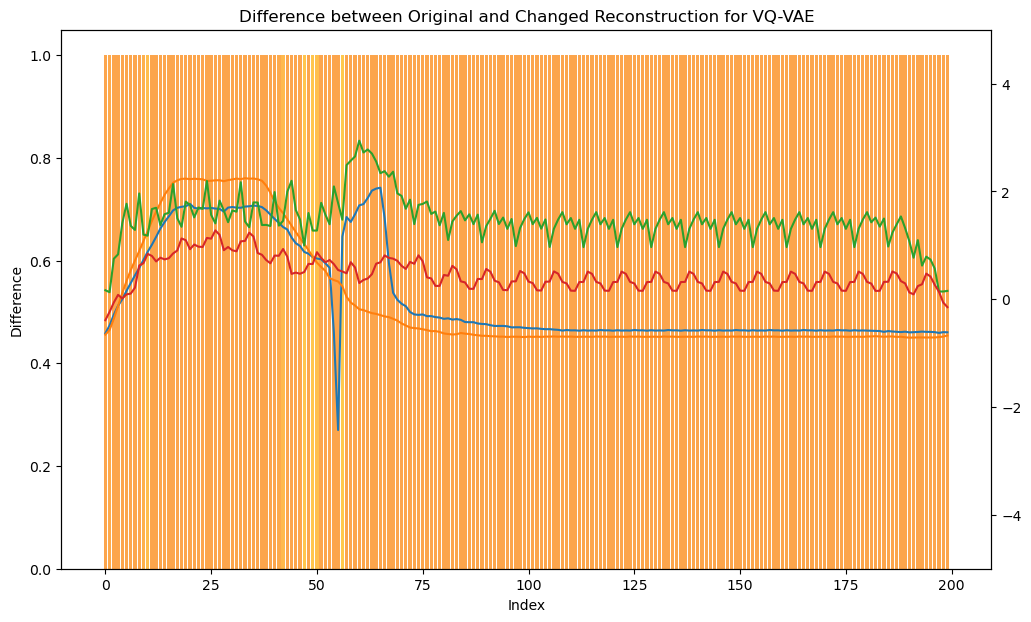

0 199
Amount of Differences:  200
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Originl Q-Embeddings Indices:  [ 47  49 207 207 207 149 251  87  88 116 151 214 214 133 133 133 133 133
 133 133 133 133 133 133 133  98]


In [92]:
def plot_reconstruction_difference_v2(reconstructed_original, reconstructed_changed, original, label, plot_original=False):
    difference = torch.sum(torch.abs(reconstructed_original - reconstructed_changed), dim=1)
    colormap = plt.colormaps['Wistia']
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 7)
    ax2 = ax.twinx()
    bars = ax.bar(np.arange(len(reconstructed_original)), [1] * len(reconstructed_original), color=colormap(difference), alpha=0.7)
    # ax.plot(difference, color='black', linewidth=2)
    # ax.set_ylim(0, 1)
    ax2.set_ylim(-5, 5)
    ax.set_xlabel('Index')
    ax.set_ylabel('Difference')
    ax2.plot(reconstructed_original)
    ax2.plot(reconstructed_changed)
    # label fig
    ax.set_title(f'Difference between Original and Changed Reconstruction for {label}')
    if plot_original: ax2.plot(original)
    plt.show()
    return difference

def alter_q_data_v3(model_dict, test_dpt, original_data, alter_range, alter_slice, alter_value, plot_original=False):
    q_emb = model_dict["q_emb"][test_dpt]
    q_ind = model_dict["q_ind"][test_dpt]
    model = model_dict["model"]
    model_hparams = model_dict["hparams"]
    label = model_dict["type"]

    if 'use_improved_vq' not in model_hparams: model_hparams['use_improved_vq'] = None
    if model_hparams["use_improved_vq"]:
        codebook = torch.round(model.vector_quantization.vq.codebooks[0], decimals=3)
    else:
        codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)

    changed_q_data = q_emb.clone().detach()
    changed_q_indices = q_ind.copy()

    for i in alter_range:
        changed_q_data[i][alter_slice] = alter_value
        # changed_q_data[i] = codebook[alter_value] 
        if label=='VQ-VAE-Patch':
            changed_q_indices[i+8] = alter_value
            changed_q_data[i+8] = codebook[alter_value] 

    reconstructed_original, _= send_through_decoder(model=model, q_data=q_emb.unsqueeze(0), original_data = original_data, label=label)
    reconstructed_changed, _= send_through_decoder(model=model, q_data=changed_q_data.unsqueeze(0), original_data = original_data, label=label)
    difference = plot_reconstruction_difference_v2(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=original_data, label=label, plot_original=plot_original)
    return changed_q_data, changed_q_indices, difference

test_dpt = 3
original_data =torch.tensor(train_data[test_dpt])

current_model = get_files_and_models(vqvae_v1_files)
# fig, ax = plt.subplots()

# create empty tensor for summing up differencs
all_differences = torch.zeros(200)

# for i in range(0,24):
changed_q_data, changed_q_indices, difference = alter_q_data_v3(current_model, test_dpt, original_data, range(0,26), slice(0,16), -2.4)
# print("Originl Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])
# print("Changed Q-Embeddings Indices: ", changed_q_indices)
my_difference = np.where(difference > 0)[0]
if len(my_difference) > 0:
    print(np.where(difference > 0)[0][0], np.where(difference > 0)[0][-1])
    print("Amount of Differences: ", len(np.where(difference > 0)[0]))
else:
    print("No Differences for ", i)
all_differences += difference
print(my_difference)
# ax.plot(all_differences, color='black', linewidth=2)
colormap = plt.colormaps['Wistia']
# print(min(all_differences), max(all_differences))

# scale data
denominator = max(all_differences) - 0
scaled_data = [(datum-min(all_differences))/denominator for datum in all_differences]

# bars = ax.bar(np.arange(len(original_data)), [1] * len(original_data), color=colormap(scaled_data), alpha=1)
# plt.show()

print("Originl Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])

# UMAP Experiments

In [34]:
patch_vqvae_v1["q_ind"][0]

array([ 37,  24, 178, 131,  10,   5, 238, 211,  31, 181, 178,  10,  17,
        60,  60,  19])

There are  90  unique codebook embeddings used to represent the data


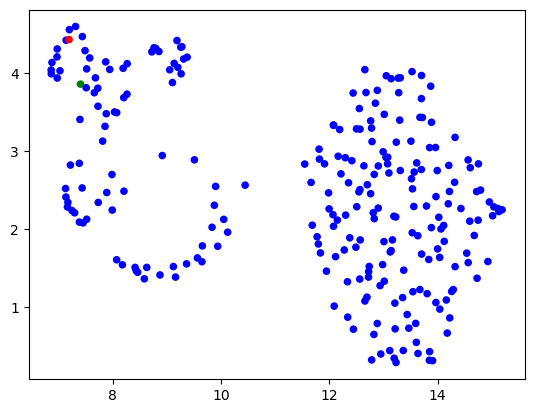

In [26]:
import umap
current_model = get_files_and_models(vqvae_v1_files)
codebook = current_model["codebook"]
# reducer = umap.UMAP(verbose=True, random_state=42)
# reducer.fit_transform(codebook)

# with open('umap_reducer_patch_v4.pkl', 'wb') as f:
#     pickle.dump(reducer, f)
with open('umap_reducer.pkl', 'rb') as f:
    loaded_reducer = pickle.load(f)

codebook_umap = loaded_reducer.transform(codebook)
# plt.scatter(codebook_umap[:, 0], codebook_umap[:, 1])

# Q Indices before:  [ 47  49 207 207 207 149 251  87  88 116 151 214 214 133 133 133 133 133
#  133 133 133 133 133 133 133  98]
# Q Indices after:  [ 47  49 207 207 207 149 251  87  88 116 151 214 222  21 149 207 207 207
#  149 144 209 225 153   3 214  98]


unique, counts = np.unique(current_model["q_ind"][:,:], return_counts=True)
print("There are ", len(unique), " unique codebook embeddings used to represent the data")
color_array = np.full((256, ), 'b')
# for i in unique[np.argsort(counts)][-80:]:
#     color_array[i] = 'r'
# for i in [222, 21, 149, 207, 144, 209, 225, 153, 3, 214, 98]:
#     color_array[i] = 'r'
# for i in [47,  49, 207, 149, 251,  87,  88, 116, 151, 214]:
#     color_array[i] = 'y'
for i in [225]:
    color_array[i] = 'r'
for i in [88]:
    color_array[i] = 'g'
# for i in [4,   97,  221,  168]:
#     color_array[i] = 'y'


plt.scatter(codebook_umap[:, 0], codebook_umap[:, 1], c=color_array, s=20)
# plt.scatter(codebook_umap[42, 0], codebook_umap[42, 1], c='r', s=20)

plt.show()
